In [21]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import random

def compute_energy(charges):
    """Compute the energy of a configuration of charges"""
    energy = 0.0
    for i in range(len(charges)):
        for j in range(i+1, len(charges)):
            dx = charges[i][0] - charges[j][0]
            dy = charges[i][1] - charges[j][1]
            dist = np.sqrt(dx**2 + dy**2)
            if dist > 0:  # Avoid division by zero
                energy += 1.0 / dist
    return energy

def compute_energy_gradients(charges):
    """Compute the gradient of energy for each charge"""
    n = len(charges)
    gradients = [(0.0, 0.0) for _ in range(n)]
    
    for i in range(n):
        for j in range(n):
            if i != j:
                dx = charges[i][0] - charges[j][0]
                dy = charges[i][1] - charges[j][1]
                dist = np.sqrt(dx**2 + dy**2)
                
                if dist > 1e-10:  # Avoid numerical issues
                    # Force is proportional to 1/r²
                    force = 1.0 / (dist**3)
                    gradients[i] = (
                        gradients[i][0] + force * dx,
                        gradients[i][1] + force * dy
                    )
    
    return gradients

def initialize_charges(n, on_circle=True):
    """Initialize n charges either on the unit circle or within the unit disk"""
    charges = []
    for _ in range(n):
        if on_circle:
            # Place on circle
            theta = np.random.uniform(0, 2*np.pi)
            charges.append((np.cos(theta), np.sin(theta)))
        else:
            # Place within disk
            r = np.sqrt(np.random.uniform(0, 1))
            theta = np.random.uniform(0, 2*np.pi)
            charges.append((r * np.cos(theta), r * np.sin(theta)))
    return charges

def plot_charges(charges, title="Charge Configuration"):
    """Plot the charges on the unit circle"""
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Draw unit circle
    circle = plt.Circle((0, 0), 1, fill=False, color='black', linestyle='--')
    ax.add_patch(circle)
    
    # Plot charges
    x = [c[0] for c in charges]
    y = [c[1] for c in charges]
    ax.scatter(x, y, color='blue', s=100, zorder=2)
    
    # Add annotations
    for i, (xi, yi) in enumerate(zip(x, y)):
        ax.annotate(str(i+1), (xi, yi), fontsize=8)
    
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_title(f"{title}\nEnergy: {compute_energy(charges):.4f}")
    
    plt.show()

In [22]:
def gradient_descent(n, learning_rate=0.01, iterations=2000, momentum=0.9, on_circle=True):
    """Gradient descent with momentum and adaptive learning rate"""
    charges = initialize_charges(n, on_circle)
    prev_gradients = [(0.0, 0.0) for _ in range(n)]
    best_energy = float('inf')
    best_charges = charges.copy()
    
    # For adaptive learning rate
    patience = 5
    patience_counter = 0
    prev_energy = compute_energy(charges)
    
    for it in range(iterations):
        gradients = compute_energy_gradients(charges)
        
        for i in range(n):
            # Apply momentum
            dx = momentum * prev_gradients[i][0] - learning_rate * gradients[i][0]
            dy = momentum * prev_gradients[i][1] - learning_rate * gradients[i][1]
            
            # Update position
            charges[i] = (charges[i][0] + dx, charges[i][1] + dy)
            
            # Enforce constraint
            if on_circle:
                # Project back to circle
                magnitude = np.sqrt(charges[i][0]**2 + charges[i][1]**2)
                charges[i] = (charges[i][0]/magnitude, charges[i][1]/magnitude)
            else:
                # Keep within unit disk
                magnitude = np.sqrt(charges[i][0]**2 + charges[i][1]**2)
                if magnitude > 1:
                    charges[i] = (charges[i][0]/magnitude, charges[i][1]/magnitude)
            
            # Save current gradient for momentum
            prev_gradients[i] = (dx, dy)
        
        # Check energy and keep best configuration
        current_energy = compute_energy(charges)
        if current_energy < best_energy:
            best_energy = current_energy
            best_charges = charges.copy()
        
        # Adaptive learning rate
        if current_energy > prev_energy:
            patience_counter += 1
            if patience_counter >= patience:
                learning_rate *= 0.5
                patience_counter = 0
                print(f"Iteration {it}: Reducing learning rate to {learning_rate}")
        else:
            patience_counter = 0
        
        prev_energy = current_energy
        
        # Optional: Early stopping
        if learning_rate < 1e-8:
            print(f"Stopping at iteration {it}: Learning rate too small")
            break
            
    return best_charges, best_energy

In [23]:
from scipy.optimize import differential_evolution

def objective_function(x, n):
    """Reshape the flat array into charges and compute energy"""
    charges = [(x[2*i], x[2*i+1]) for i in range(n)]
    return compute_energy(charges)

def circle_constraint(x):
    """Constraint function for keeping points on/within the unit circle"""
    n = len(x) // 2
    constraints = []
    for i in range(n):
        constraints.append(1.0 - (x[2*i]**2 + x[2*i+1]**2))
    return np.array(constraints)

def solve_with_de(n, on_circle=True, maxiter=1000, popsize=15):
    """Solve Thomson problem using Differential Evolution"""
    # Set bounds for each variable (all coordinates between -1 and 1)
    bounds = [(-1, 1)] * (2*n)
    
    # Set constraints based on whether points should be on or within circle
    if on_circle:
        constraints = ({'type': 'eq', 
                        'fun': lambda x: np.array([x[2*i]**2 + x[2*i+1]**2 - 1.0 for i in range(n)])})
    else:
        constraints = ({'type': 'ineq', 
                        'fun': lambda x: np.array([1.0 - (x[2*i]**2 + x[2*i+1]**2) for i in range(n)])})
    
    result = differential_evolution(
        lambda x: objective_function(x, n), 
        bounds,
        constraints=constraints,
        maxiter=maxiter,
        popsize=popsize,
        tol=1e-8,
        polish=True  # Use local optimization at the end
    )
    
    # Reshape the solution back to list of (x,y) pairs
    charges = [(result.x[2*i], result.x[2*i+1]) for i in range(n)]
    
    # For on_circle=True, normalize to ensure all points are exactly on the circle
    if on_circle:
        charges = [(x/np.sqrt(x**2+y**2), y/np.sqrt(x**2+y**2)) for x, y in charges]
    
    return charges, result.fun

In [24]:
def solve_with_pso(n, on_circle=True, max_iter=100, swarm_size=100):
    """Custom Particle Swarm Optimization implementation for Thomson problem"""
    # PSO parameters
    w = 0.5  # Inertia weight
    c1 = 1.5  # Cognitive parameter
    c2 = 1.5  # Social parameter
    
    # Initialize swarm positions and velocities
    swarm = []
    velocities = []
    for _ in range(swarm_size):
        if on_circle:
            # Initialize on circle
            particle = []
            for _ in range(n):
                theta = np.random.uniform(0, 2*np.pi)
                particle.extend([np.cos(theta), np.sin(theta)])
        else:
            # Initialize within disk
            particle = []
            for _ in range(n):
                r = np.sqrt(np.random.uniform(0, 1))
                theta = np.random.uniform(0, 2*np.pi)
                particle.extend([r * np.cos(theta), r * np.sin(theta)])
        
        swarm.append(np.array(particle))
        velocities.append(np.random.uniform(-0.1, 0.1, size=2*n))
    
    # Personal best positions and scores
    p_best_positions = swarm.copy()
    p_best_scores = [objective_function(p, n) for p in swarm]
    
    # Global best position and score
    g_best_idx = np.argmin(p_best_scores)
    g_best_position = p_best_positions[g_best_idx].copy()
    g_best_score = p_best_scores[g_best_idx]
    
    # Main PSO loop
    for _ in range(max_iter):
        for i in range(swarm_size):
            # Update velocity
            r1, r2 = np.random.random(2)
            velocities[i] = (w * velocities[i] + 
                            c1 * r1 * (p_best_positions[i] - swarm[i]) + 
                            c2 * r2 * (g_best_position - swarm[i]))
            
            # Update position
            swarm[i] += velocities[i]
            
            # Apply constraints
            if on_circle:
                for j in range(n):
                    # Project back to circle
                    x, y = swarm[i][2*j], swarm[i][2*j+1]
                    magnitude = np.sqrt(x**2 + y**2)
                    if magnitude > 0:  # Avoid division by zero
                        swarm[i][2*j] = x / magnitude
                        swarm[i][2*j+1] = y / magnitude
            else:
                for j in range(n):
                    # Keep within unit disk
                    x, y = swarm[i][2*j], swarm[i][2*j+1]
                    magnitude = np.sqrt(x**2 + y**2)
                    if magnitude > 1:
                        swarm[i][2*j] = x / magnitude
                        swarm[i][2*j+1] = y / magnitude
            
            # Evaluate new position
            current_score = objective_function(swarm[i], n)
            
            # Update personal best
            if current_score < p_best_scores[i]:
                p_best_scores[i] = current_score
                p_best_positions[i] = swarm[i].copy()
                
                # Update global best
                if current_score < g_best_score:
                    g_best_score = current_score
                    g_best_position = swarm[i].copy()
    
    # Convert the result to charges format
    charges = [(g_best_position[2*i], g_best_position[2*i+1]) for i in range(n)]
    
    return charges, g_best_score

In [25]:
from scipy.optimize import basinhopping, minimize

def basin_hopping_objective(x, n, on_circle):
    """Objective function with circle constraint handling"""
    # Reshape the flat array into charges
    charges = [(x[2*i], x[2*i+1]) for i in range(n)]
    
    # Add penalty for violating constraints
    penalty = 0
    if on_circle:
        for i in range(n):
            # Penalty for not being on circle
            r_squared = x[2*i]**2 + x[2*i+1]**2
            penalty += 1000 * (r_squared - 1)**2
    else:
        for i in range(n):
            # Penalty for being outside circle
            r_squared = x[2*i]**2 + x[2*i+1]**2
            if r_squared > 1:
                penalty += 1000 * (r_squared - 1)**2
    
    return compute_energy(charges) + penalty

def custom_step_taking(x):
    """Custom step taking function that respects circle constraints"""
    n = len(x) // 2
    new_x = x.copy()
    
    # Perturb a random point
    i = np.random.randint(0, n)
    
    # Get current position
    current_x = x[2*i]
    current_y = x[2*i+1]
    
    # Generate perturbation (in polar coordinates for better moves)
    r = np.sqrt(current_x**2 + current_y**2)
    theta = np.arctan2(current_y, current_x)
    
    # Perturb angle
    theta_new = theta + np.random.normal(0, 0.5)
    
    # Keep r=1 for on_circle constraint, or perturb r for disk
    r_new = 1.0  # Can modify to allow perturbation within disk if needed
    
    # Convert back to Cartesian
    new_x[2*i] = r_new * np.cos(theta_new)
    new_x[2*i+1] = r_new * np.sin(theta_new)
    
    return new_x

def solve_with_basin_hopping(n, on_circle=True, niter=100, T=1.0):
    """Enhanced Basin Hopping optimizer for Thomson problem"""
    # Initial guess - on unit circle
    initial_guess = []
    for _ in range(n):
        theta = np.random.uniform(0, 2*np.pi)
        initial_guess.extend([np.cos(theta), np.sin(theta)])
    
    # Define minimizer options
    if on_circle:
        # For points exactly on circle, use custom constraints
        minimizer_kwargs = {
            "method": "SLSQP",
            "args": (n, on_circle),
            "constraints": [{"type": "eq", "fun": lambda x, i=i: x[2*i]**2 + x[2*i+1]**2 - 1} 
                            for i in range(n)],
            "options": {"ftol": 1e-8, "maxiter": 1000}
        }
    else:
        # For points within disk, use bounds
        minimizer_kwargs = {
            "method": "L-BFGS-B",
            "bounds": [(-1, 1)] * (2*n),
            "args": (n, on_circle),
            "options": {"ftol": 1e-8, "maxiter": 1000}
        }
    
    # Create a custom take_step function (optional)
    take_step = custom_step_taking if on_circle else None
    
    # Run basin hopping
    result = basinhopping(
        basin_hopping_objective, 
        initial_guess,
        minimizer_kwargs=minimizer_kwargs,
        niter=niter,
        T=T,
        take_step=take_step,
        interval=20  # Adjust accept rate every 20 steps
    )
    
    # Format result
    x_opt = result.x
    charges = [(x_opt[2*i], x_opt[2*i+1]) for i in range(n)]
    
    # Ensure points are exactly on circle if needed
    if on_circle:
        charges = [(x/np.sqrt(x**2+y**2), y/np.sqrt(x**2+y**2)) for x, y in charges]
    
    # Calculate final energy without constraint penalties
    final_energy = compute_energy(charges)
    
    return charges, final_energy

In [26]:
def simulated_annealing(n, on_circle=True, initial_temp=1.0, cooling_rate=0.95, steps_per_temp=100, min_temp=1e-6):
    """Full implementation of simulated annealing for Thomson problem"""
    # Initialize charges
    charges = initialize_charges(n, on_circle)
    current_energy = compute_energy(charges)
    
    # Keep track of best solution
    best_charges = charges.copy()
    best_energy = current_energy
    
    # Initialize temperature
    T = initial_temp
    
    # For statistics
    accepted = 0
    total = 0
    
    while T > min_temp:
        for _ in range(steps_per_temp):
            # Choose a random charge to move
            i = np.random.randint(0, n)
            
            # Make a copy of current charges
            new_charges = charges.copy()
            
            if on_circle:
                # Move on circle (change angle)
                x, y = charges[i]
                theta = np.arctan2(y, x)
                
                # Perturb angle (larger steps at higher temperatures)
                delta_theta = np.random.normal(0, 0.1 * T)
                new_theta = theta + delta_theta
                
                # Update position
                new_charges[i] = (np.cos(new_theta), np.sin(new_theta))
            else:
                # Move within disk
                x, y = charges[i]
                
                # Random direction and step size
                dx = np.random.normal(0, 0.1 * T)
                dy = np.random.normal(0, 0.1 * T)
                
                # Update position
                new_x = x + dx
                new_y = y + dy
                
                # Keep within unit disk
                magnitude = np.sqrt(new_x**2 + new_y**2)
                if magnitude > 1:
                    new_x /= magnitude
                    new_y /= magnitude
                    
                new_charges[i] = (new_x, new_y)
            
            # Calculate new energy
            new_energy = compute_energy(new_charges)
            
            # Decide whether to accept the move
            delta_e = new_energy - current_energy
            total += 1
            
            # Accept if better or with probability exp(-delta_e/T)
            if delta_e < 0 or np.random.random() < np.exp(-delta_e / T):
                charges = new_charges
                current_energy = new_energy
                accepted += 1
                
                # Update best solution if needed
                if current_energy < best_energy:
                    best_energy = current_energy
                    best_charges = charges.copy()
        
        # Cool down temperature
        T *= cooling_rate
        
        # Optional: print progress
        if total > 0:
            accept_rate = accepted / total
            print(f"T: {T:.6f}, Energy: {current_energy:.6f}, Accept rate: {accept_rate:.4f}")
            accepted = 0
            total = 0
    
    return best_charges, best_energy

In [27]:
def compare_methods(n, methods=None):
    """Compare different optimization methods for the Thomson problem"""
    if methods is None:
        methods = ["gradient_descent", "differential_evolution", 
                   "basin_hopping", "simulated_annealing", "pso"]
    
    results = {}
    
    for method_name in methods:
        print(f"\nRunning {method_name} for n={n}...")
        
        if method_name == "gradient_descent":
            charges, energy = gradient_descent(n, on_circle=False)
        elif method_name == "differential_evolution":
            charges, energy = solve_with_de(n, on_circle=False)
        elif method_name == "basin_hopping":
            charges, energy = solve_with_basin_hopping(n, on_circle=False)
        elif method_name == "simulated_annealing":
            charges, energy = simulated_annealing(n, on_circle=False)
        elif method_name == "pso":
            charges, energy = solve_with_pso(n, on_circle=False)
        
        results[method_name] = {
            "charges": charges,
            "energy": energy
        }
        
        print(f"{method_name} - Energy: {energy:.6f}")
    
    # Find the best method
    best_method = min(results.items(), key=lambda x: x[1]["energy"])
    print(f"\nBest method for n={n}: {best_method[0]} with energy {best_method[1]['energy']:.6f}")
    
    # Plot the best configuration
    plot_charges(best_method[1]["charges"], 
                f"Best Configuration (n={n}) using {best_method[0]}")
    
    return results


Running gradient_descent for n=16...
Iteration 212: Reducing learning rate to 0.005
Iteration 808: Reducing learning rate to 0.0025
Iteration 914: Reducing learning rate to 0.00125
Iteration 1321: Reducing learning rate to 0.000625
Iteration 1380: Reducing learning rate to 0.0003125
Iteration 1385: Reducing learning rate to 0.00015625
Iteration 1390: Reducing learning rate to 7.8125e-05
Iteration 1395: Reducing learning rate to 3.90625e-05
Iteration 1404: Reducing learning rate to 1.953125e-05
Iteration 1461: Reducing learning rate to 9.765625e-06
Iteration 1527: Reducing learning rate to 4.8828125e-06
Iteration 1547: Reducing learning rate to 2.44140625e-06
Iteration 1557: Reducing learning rate to 1.220703125e-06
Iteration 1562: Reducing learning rate to 6.103515625e-07
Iteration 1585: Reducing learning rate to 3.0517578125e-07
Iteration 1590: Reducing learning rate to 1.52587890625e-07
Iteration 1595: Reducing learning rate to 7.62939453125e-08
Iteration 1600: Reducing learning rat

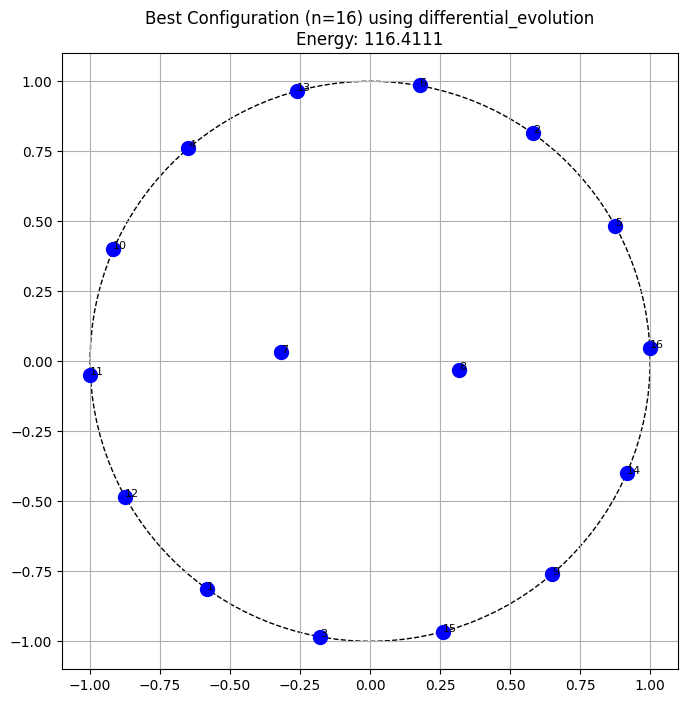

T: 0.950000, Energy: 154.675389, Accept rate: 0.5800
T: 0.902500, Energy: 145.641869, Accept rate: 0.6900
T: 0.857375, Energy: 139.363183, Accept rate: 0.7600
T: 0.814506, Energy: 134.149962, Accept rate: 0.7100
T: 0.773781, Energy: 129.356974, Accept rate: 0.5900
T: 0.735092, Energy: 125.349060, Accept rate: 0.6900
T: 0.698337, Energy: 125.468414, Accept rate: 0.6600
T: 0.663420, Energy: 122.458959, Accept rate: 0.7900
T: 0.630249, Energy: 122.409863, Accept rate: 0.6200
T: 0.598737, Energy: 124.440004, Accept rate: 0.7000
T: 0.568800, Energy: 123.490473, Accept rate: 0.7400
T: 0.540360, Energy: 120.715114, Accept rate: 0.7200
T: 0.513342, Energy: 121.321449, Accept rate: 0.6600
T: 0.487675, Energy: 124.165026, Accept rate: 0.7100
T: 0.463291, Energy: 126.801243, Accept rate: 0.7800
T: 0.440127, Energy: 124.067884, Accept rate: 0.6500
T: 0.418120, Energy: 125.127503, Accept rate: 0.7400
T: 0.397214, Energy: 123.502998, Accept rate: 0.7200
T: 0.377354, Energy: 124.865857, Accept rate: 

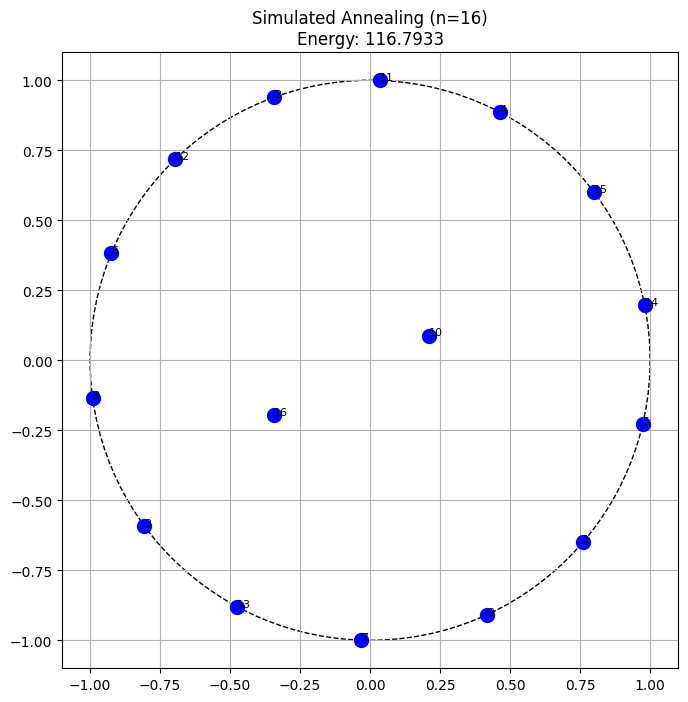

In [34]:
# Override the differential_evolution function with a penalty-based approach
def solve_with_de(n, on_circle=False, maxiter=1000, popsize=15):
	"""Solve Thomson problem using Differential Evolution with penalty approach"""
	# Set bounds for each variable (all coordinates between -1 and 1)
	bounds = [(-1, 1)] * (2*n)
	
	def penalized_objective(x):
		# Reshape the flat array into charges
		charges = [(x[2*i], x[2*i+1]) for i in range(n)]
		
		# Compute energy
		energy = compute_energy(charges)
		
		# Add penalty for constraint violations
		penalty = 0
		for i in range(n):
			r_squared = x[2*i]**2 + x[2*i+1]**2
			if on_circle:
				# Penalty for not being on circle
				penalty += 1000 * (r_squared - 1)**2
			else:
				# Penalty for being outside circle
				if r_squared > 1:
					penalty += 1000 * (r_squared - 1)**2
		
		return energy + penalty
	
	result = differential_evolution(
		penalized_objective, 
		bounds,
		maxiter=maxiter,
		popsize=popsize,
		tol=1e-8,
		polish=True  # Use local optimization at the end
	)
	
	# Reshape the solution back to list of (x,y) pairs
	charges = [(result.x[2*i], result.x[2*i+1]) for i in range(n)]
	
	# For on_circle=True, normalize to ensure all points are exactly on the circle
	if on_circle:
		charges = [(x/np.sqrt(x**2+y**2), y/np.sqrt(x**2+y**2)) for x, y in charges]
	
	# Compute final energy (without penalties)
	final_energy = compute_energy(charges)
	
	return charges, final_energy

# Example usage
n = 16 # Number of charges
results = compare_methods(n)

# Or run a specific method
charges, energy = simulated_annealing(n, on_circle=False)
plot_charges(charges, f"Simulated Annealing (n={n})")

In [ ]:
def multi_start_basin_hopping(n, num_trials=5, on_circle=True):
    """Run basin hopping multiple times and return the best result"""
    best_energy = float('inf')
    best_charges = None
    
    for trial in range(num_trials):
        print(f"Trial {trial + 1}/{num_trials}")
        charges, energy = solve_with_basin_hopping(n, on_circle=on_circle)
        
        if energy < best_energy:
            best_energy = energy
            best_charges = charges
    
    print(f"Best energy from {num_trials} trials: {best_energy:.6f}")
    return best_charges, best_energy

In [ ]:
multi_start_basin_hopping(n, num_trials=5, on_circle=False)
# This function can be called to run multiple trials of basin hopping
# and find the best configuration of charges.
plot_charges(, f"Best Configuration from Multi-Start Basin Hopping (n={n})")
# This function can be called to plot the best configuration found


Trial 1/5
Trial 2/5
Trial 3/5
Trial 4/5
Trial 5/5
Best energy from 5 trials: 59.535456


NameError: name 'best_charges' is not defined